# Cats vs Dogs

In [1]:
# standard packages
import pandas as pd
import numpy as np
import seaborn as sns

# keras packages
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import History, TensorBoard

import tensorflow as tf

# sklearn packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


### Images

In [2]:
train_path = '/mnt/DataDisk/jodahr/data/catsVsDogs/train_min/'
val_path = '/mnt/DataDisk/jodahr/data/catsVsDogs/validation/'

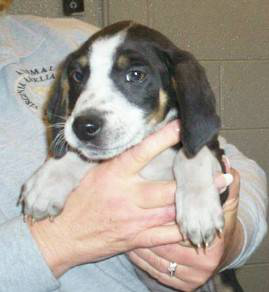

In [3]:
dog = load_img(train_path + 'dogs/dog.10.jpg')
dog

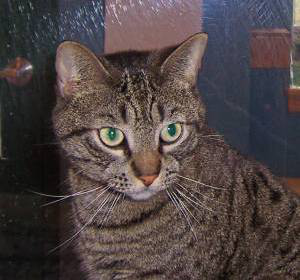

In [4]:
cat = load_img(train_path + 'cats/cat.1.jpg')
cat

In [5]:
cat_arr = img_to_array(cat)
dog_arr = img_to_array(dog)

In [6]:
cat_arr.shape

(280, 300, 3)

In [7]:
dog_arr.shape

(292, 269, 3)

#### resize

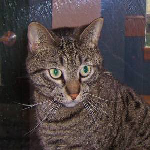

In [8]:
cat = load_img(train_path + 'cats/cat.1.jpg', target_size=(150,150))
cat

### data augmentation

In [9]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [10]:
# transform to rank/dim for input
# Insert a new axis that will appear at the axis position in the expanded array shape.
x = np.expand_dims(cat_arr, axis=0)
x.shape

(1, 280, 300, 3)

In [11]:
for i in range(10):
    augmented_arr = datagen.flow(x, batch_size=1).next()
    augmented_img = array_to_img(np.squeeze(augmented_arr, axis=0))
    augmented_img.save('/mnt/DataDisk/jodahr/data/catsVsDogs/augmented/' + str(i) + '.png')

## Image Data Generator for Training and Validation

In [12]:
print(x[0,:,:,:].max())
print(x[0,:,:,:].min())

255.0
0.0


In [13]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255, # to scale between 0 and 1
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

## Keras Model

In [14]:
img_width = 150
img_height = 150

In [15]:
# to adjust for the backend (here tensorflow)
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [16]:
input_shape

(150, 150, 3)

- **Convolution**: Clever reduction of dimensions via Matrix Multiplication
- **MaxPooling**: transforms e.g. 2x2 pixel matrix to the maximum pixel value

In [17]:
model = Sequential()

In [18]:
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [20]:
# loads 50 images into memory; propagates forwards and backwards (updating weights) using 1 batch
batch_size = 100
epochs = 50

In [21]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    val_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [22]:
nb_train_samples = 2000
nb_validation_samples = 800

In [23]:
# callbacks
history = History()
tb = TensorBoard()

### train on gpu

In [24]:
with tf.device('/gpu:0'):
    model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks = [history, tb])

Epoch 1/50
20/20 [==============================] - 21s 1s/step - loss: 0.8217 - acc: 0.5125 - val_loss: 0.6874 - val_acc: 0.5487
Epoch 2/50
20/20 [==============================] - 10s 481ms/step - loss: 0.6838 - acc: 0.5375 - val_loss: 0.7310 - val_acc: 0.5000
Epoch 3/50
20/20 [==============================] - 10s 505ms/step - loss: 0.6938 - acc: 0.5470 - val_loss: 0.6630 - val_acc: 0.6325
Epoch 4/50
20/20 [==============================] - 10s 504ms/step - loss: 0.6639 - acc: 0.6030 - val_loss: 0.6683 - val_acc: 0.5687
Epoch 5/50
20/20 [==============================] - 10s 512ms/step - loss: 0.6500 - acc: 0.6220 - val_loss: 0.6142 - val_acc: 0.6700
Epoch 6/50
20/20 [==============================] - 10s 511ms/step - loss: 0.6255 - acc: 0.6475 - val_loss: 0.5834 - val_acc: 0.7137
Epoch 7/50
20/20 [==============================] - 12s 607ms/step - loss: 0.6167 - acc: 0.6430 - val_loss: 0.8469 - val_acc: 0.5275
Epoch 8/50
20/20 [==============================] - 8s 418ms/step - loss

In [25]:
model.save('model.h5')

In [27]:
model.layers

In [103]:
from vis.visualization import visualize_cam, get_num_filters
from matplotlib import pyplot as plt

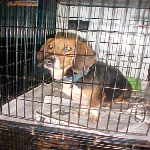

In [148]:
dog = load_img('/mnt/DataDisk/jodahr/data/catsVsDogs/validation/dogs/dog.9685.jpg', target_size=(150,150))
dog

In [149]:
dog_arr = img_to_array(dog) * 1./255.

In [150]:
dog_arr_exp = np.expand_dims(dog_arr, axis=0)
dog_arr_exp.shape

(1, 150, 150, 3)

In [151]:
cam_array = visualize_cam(model, 5, filter_indices=None, seed_input=dog_arr_exp)

In [152]:
get_num_filters(model.layers[8])

64

In [153]:
%matplotlib inline

In [154]:
cam_array.shape

(150, 150, 3)

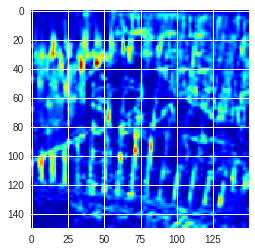

In [155]:
plt.imshow(cam_array, interpolation='nearest')